# Environment Setup

In [0]:
from pyspark.sql import SparkSession
# Start a new Spark session
spark = SparkSession.builder.appName("YourApp").getOrCreate()

In [0]:
import pyspark
from pyspark import SparkContext 
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, sum, count, when, avg, udf, round

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
raw = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/mchu@clarku.edu/ad_click_dataset.csv")

# Check the DataFrame
raw.show()

+----+---------+----+----------+-----------+-----------+----------------+-----------+-----+
|  id|full_name| age|    gender|device_type|ad_position|browsing_history|time_of_day|click|
+----+---------+----+----------+-----------+-----------+----------------+-----------+-----+
| 670|  User670|22.0|      null|    Desktop|        Top|        Shopping|  Afternoon|    1|
|3044| User3044|null|      Male|    Desktop|        Top|            null|       null|    1|
|5912| User5912|41.0|Non-Binary|       null|       Side|       Education|      Night|    1|
|5418| User5418|34.0|      Male|       null|       null|   Entertainment|    Evening|    1|
|9452| User9452|39.0|Non-Binary|       null|       null|    Social Media|    Morning|    0|
|5942| User5942|null|Non-Binary|       null|     Bottom|    Social Media|    Evening|    1|
|7808| User7808|26.0|    Female|    Desktop|        Top|            null|       null|    1|
|5065| User5065|40.0|      Male|     Mobile|       Side|            null|    Eve

# EDA

In [0]:
# Total number of rows in the DataFrame
total_rows = raw.count()
print("total row number:", total_rows)


# Calculate missing value
null_counts = raw.select([sum(col(c).isNull().cast("int")).alias(c) for c in raw.columns])
# Show the result
print("null_count:")
null_counts.show()

# Calculate the percentage of null values in each column
null_percentage = raw.select([(count(when(col(c).isNull(), c)) / total_rows * 100).alias(c) for c in raw.columns])

# Show the result
print("null_percentage:")
null_percentage.show()

total row number: 10000
null_count:
+---+---------+----+------+-----------+-----------+----------------+-----------+-----+
| id|full_name| age|gender|device_type|ad_position|browsing_history|time_of_day|click|
+---+---------+----+------+-----------+-----------+----------------+-----------+-----+
|  0|        0|4766|  4693|       2000|       2000|            4782|       2000|    0|
+---+---------+----+------+-----------+-----------+----------------+-----------+-----+

null_percentage:
+---+---------+------------------+------+-----------+-----------+----------------+-----------+-----+
| id|full_name|               age|gender|device_type|ad_position|browsing_history|time_of_day|click|
+---+---------+------------------+------+-----------+-----------+----------------+-----------+-----+
|0.0|      0.0|47.660000000000004| 46.93|       20.0|       20.0|           47.82|       20.0|  0.0|
+---+---------+------------------+------+-----------+-----------+----------------+-----------+-----+



In [0]:
# is the browsing history missing same as other demographic missing?
# is age missing same as gender missing?
overlap_count_age_gender = raw.filter(F.col("age").isNull() & F.col("gender").isNull()).count()
overlap_count_device_position = raw.filter(F.col("device_type").isNull() & F.col("ad_position").isNull()).count()
overlap_count_gender_browse = raw.filter(F.col("gender").isNull() & F.col("browsing_history").isNull()).count()

In [0]:
overlap_count_device_position
# device_type and position both has 2000 missing, but has only 433 overlap

Out[8]: 433

In [0]:
# overlap missing data between time and position
overlap_count_time_position = raw.filter(F.col("time_of_day").isNull() & F.col("ad_position").isNull()).count()
overlap_count_time_position

Out[9]: 408

In [0]:
overlap_count_time_device = raw.filter(F.col("time_of_day").isNull() & F.col("device_type").isNull()).count()
overlap_count_time_device

Out[10]: 375

In [0]:
overlap_count_age_gender

Out[11]: 2207

In [0]:
overlap_count_age_browse = raw.filter(F.col("age").isNull() & F.col("browsing_history").isNull()).count()
overlap_count_age_browse

Out[12]: 2334

In [0]:
overlap_count_time_browse = raw.filter(F.col("time_of_day").isNull() & F.col("browsing_history").isNull()).count()

In [0]:
overlap_count_time_browse

Out[14]: 962

#select feature and correlation checkup

In [0]:
from pyspark.ml.feature import Imputer

# build df_clean with columns we want
df = raw.select(
    "age",
    "gender",
    "device_type",
    "ad_position",
    "browsing_history",
    "time_of_day",
    "click"
)

df = df.withColumn("age", col("age").cast("double"))
df = df.withColumn("click", col("click").cast("double"))

# give missing as a kind of machine learning input for our continuous value in prediction model too
df = df.withColumn(
    "age_missing",
    when(col("age").isNull(), 1).otherwise(0)
)

# impute missing value
imputer = Imputer(
    inputCols=["age"],
    outputCols=["age"],
    strategy="median"
)

df_filled = imputer.fit(df).transform(df)

# split data
train_df, test_df = df_filled.randomSplit([0.8, 0.2], seed=42)


In [0]:
df_filled.show()

+----+----------+-----------+-----------+----------------+-----------+-----+-----------+
| age|    gender|device_type|ad_position|browsing_history|time_of_day|click|age_missing|
+----+----------+-----------+-----------+----------------+-----------+-----+-----------+
|22.0|      null|    Desktop|        Top|        Shopping|  Afternoon|  1.0|          0|
|39.0|      Male|    Desktop|        Top|            null|       null|  1.0|          1|
|41.0|Non-Binary|       null|       Side|       Education|      Night|  1.0|          0|
|34.0|      Male|       null|       null|   Entertainment|    Evening|  1.0|          0|
|39.0|Non-Binary|       null|       null|    Social Media|    Morning|  0.0|          0|
|39.0|Non-Binary|       null|     Bottom|    Social Media|    Evening|  1.0|          1|
|26.0|    Female|    Desktop|        Top|            null|       null|  1.0|          0|
|40.0|      Male|     Mobile|       Side|            null|    Evening|  0.0|          0|
|39.0|Non-Binary|    

In [0]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# 1. Categorical columns
categorical_columns = ["gender", "device_type", "ad_position",
                       "browsing_history", "time_of_day"]

# 2. Numeric columns (imputed age + missing indicator)
numeric_columns = ["age", "age_missing"]

# 3. StringIndexers for categoricals
indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=c + "_indexed",
        handleInvalid="keep"
    )
    for c in categorical_columns
]

# 4. OneHotEncoders for indexed categorical columns
encoders = [
    OneHotEncoder(
        inputCols=[c + "_indexed"],
        outputCols=[c + "_encoded"]
    )
    for c in categorical_columns
]

# 5. Feature columns = OHE + numeric
encoded_cols = [c + "_encoded" for c in categorical_columns]
feature_cols = encoded_cols + numeric_columns

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# 6. GBT model
gbt = GBTClassifier(
    labelCol="click",
    featuresCol="features",
    maxDepth=5,
    maxIter=50,
    stepSize=0.1,
    seed=42
)

# 7. Final pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, gbt])


In [0]:
# fit + predict without CV
pipeline_model = pipeline.fit(train_df)
gbt_predictions = pipeline_model.transform(test_df)

# evaluate model
evaluator = BinaryClassificationEvaluator(
    labelCol="click",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
print("GBT AUC:", evaluator.evaluate(gbt_predictions))


GBT AUC: 0.7157758505733989


In [0]:
paramGrid = (
    ParamGridBuilder()
        .addGrid(gbt.maxDepth, [3, 5, 7])
        .addGrid(gbt.maxIter, [20, 50, 80])
        .addGrid(gbt.stepSize, [0.05, 0.1])
        .build()
)# fit + predict with cross-validated pipeline with tuned hyperparams
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=4
)

cvModel = cv.fit(train_df)
bestPipeline = cvModel.bestModel


In [0]:
cv_predictions = bestPipeline.transform(test_df)
print("GBT AUC (CV):", evaluator.evaluate(cv_predictions))

GBT AUC (CV): 0.7157758505733989


In [0]:
best_gbt = bestPipeline.stages[-1]   # GBT from CV pipeline
print("maxDepth:", best_gbt.getMaxDepth())
print("maxIter:", best_gbt.getMaxIter())
print("stepSize:", best_gbt.getStepSize())


maxDepth: 5
maxIter: 50
stepSize: 0.1


I tested multiple sets of GBT hyperparameters via cross-validation (depth 3–7, iter 20–80, step sizes 0.05–0.1), and the model consistently performed best at depth 5, 50 iterations, and step size 0.1. Confirmed that deeper trees or more iterations do not improve AUC, and the current parameter is the best configure.


In [0]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

pred_pd = gbt_predictions.select("prediction", "click").toPandas()

precision = precision_score(pred_pd["click"], pred_pd["prediction"])
recall = recall_score(pred_pd["click"], pred_pd["prediction"])
f1 = f1_score(pred_pd["click"], pred_pd["prediction"])

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)


Precision: 0.7001160092807425
Recall: 0.9671474358974359
F1: 0.8122476446837147


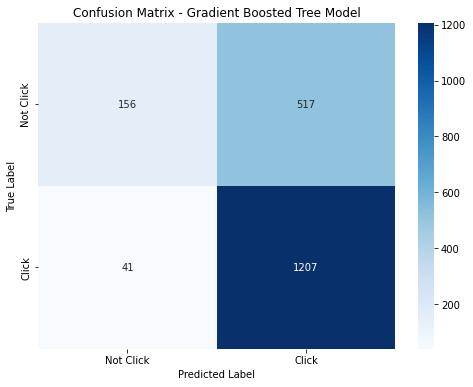

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions to pandas DataFrame
pred_pd = gbt_predictions.select("prediction", "click").toPandas()

# Compute confusion matrix
cm = confusion_matrix(pred_pd["click"], pred_pd["prediction"])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Click", "Click"],
            yticklabels=["Not Click", "Click"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gradient Boosted Tree Model")
plt.show()


In [0]:
feature_importances = pipeline_model.stages[-1].featureImportances
print(feature_importances)

(20,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[0.0423604005818379,0.055281039563842053,0.03333259714309493,0.05716433444744212,0.04846986161270267,0.0376680293398426,0.037594707055858455,0.03380715222799944,0.03466722729169133,0.013599177239885967,0.04123083220249592,0.014440006550462682,0.043430543484185326,0.03154004281630525,0.02525734441718037,0.032349639578926614,0.05412686770507405,0.051039904191920046,0.3038376471615232,0.00880264538772901])


In [0]:
cat_cols = ["gender", "device_type", "ad_position", "browsing_history", "time_of_day"]
num_cols = ["age", "age_missing"]

In [0]:
def get_feature_names_from_pipeline(pipelineModel,
                                    categorical_columns,
                                    numeric_columns,
                                    idx_suffix="_indexed"):
    stages = pipelineModel.stages
    
    # 1) Find all StringIndexerModels
    indexer_models = {
        s.getOutputCol(): s
        for s in stages
        if isinstance(s, StringIndexerModel)
    }
    
    # 2) Find the OneHotEncoderModel
    encoder_model = next(s for s in stages if isinstance(s, OneHotEncoderModel))
    drop_last = encoder_model.getDropLast()
    
    cat_feature_names = []
    baselines = {}
    
    # 3) Reconstruct one-hot expanded feature names
    for col in categorical_columns:
        idx_col = col + idx_suffix     # "gender" -> "gender_indexed"
        idx_model = indexer_models[idx_col]
        labels = idx_model.labels      # categories seen in training
        
        if drop_last:
            used_labels = labels[:-1]
            baseline = labels[-1] if labels else None
        else:
            used_labels = labels
            baseline = None
        
        baselines[col] = baseline
        expanded = [f"{col}={lab}" for lab in used_labels]
        cat_feature_names.extend(expanded)
    
    # 4) Numeric columns come last in assembler
    all_feature_names = cat_feature_names + numeric_columns
    return all_feature_names, baselines


In [0]:
all_feature_names, baselines = get_feature_names_from_pipeline(
    bestPipeline,
    categorical_columns,
    numeric_columns
)

print("Number of final features:", len(all_feature_names))


Number of final features: 15


In [0]:
from pyspark.ml.classification import GBTClassificationModel
from pyspark.sql import Row

# get the GBT model (last stage)
gbt_model = next(
    s for s in bestPipeline.stages
    if isinstance(s, GBTClassificationModel)
)

# convert SparseVector to python list
importances = gbt_model.featureImportances.toArray().tolist()

print("len(names) =", len(all_feature_names),
      "len(importances) =", len(importances))


len(names) = 15 len(importances) = 20


In [0]:
rows = [
    Row(feature=name, importance=float(score))
    for name, score in zip(all_feature_names, importances)
]

fi_df = spark.createDataFrame(rows).orderBy("importance", ascending=False)
fi_df.show(truncate=False)


+------------------------------+--------------------+
|feature                       |importance          |
+------------------------------+--------------------+
|device_type=Mobile            |0.05716433444744212 |
|gender=Female                 |0.055281039563842053|
|ad_position=Bottom            |0.04846986161270267 |
|time_of_day=Evening           |0.043430543484185326|
|gender=Male                   |0.0423604005818379  |
|time_of_day=Morning           |0.04123083220249592 |
|ad_position=Top               |0.0376680293398426  |
|browsing_history=Entertainment|0.037594707055858455|
|browsing_history=Education    |0.03466722729169133 |
|browsing_history=Social Media |0.03380715222799944 |
|device_type=Desktop           |0.03333259714309493 |
|age                           |0.03154004281630525 |
|age_missing                   |0.02525734441718037 |
|time_of_day=Afternoon         |0.014440006550462682|
|browsing_history=Shopping     |0.013599177239885967|
+---------------------------

In [0]:
print("Baseline (dropped) categories:")
for col, base in baselines.items():
    print(f"{col}: baseline = {base}")


Baseline (dropped) categories:
gender: baseline = Non-Binary
device_type: baseline = Tablet
ad_position: baseline = Side
browsing_history: baseline = News
time_of_day: baseline = Night


In [0]:
from pyspark.sql import Row

extended_rows = []

# 1) Add real OHE feature importances (already extracted)
for name, score in zip(all_feature_names, importances):
    extended_rows.append(Row(feature=name, importance=float(score), baseline=False))

# 2) Add baseline categories with importance = 0
for col, base in baselines.items():
    if base is not None:
        baseline_name = f"{col}={base}"
        extended_rows.append(
            Row(feature=baseline_name, importance=0.0, baseline=True)
        )

# Create DataFrame
extended_df = spark.createDataFrame(extended_rows)

# Sort however you prefer — by importance or grouped by feature
extended_df = extended_df.orderBy("importance", ascending=False)

extended_df.show(50, truncate=False)


+------------------------------+--------------------+--------+
|feature                       |importance          |baseline|
+------------------------------+--------------------+--------+
|device_type=Mobile            |0.05716433444744212 |false   |
|gender=Female                 |0.055281039563842053|false   |
|ad_position=Bottom            |0.04846986161270267 |false   |
|time_of_day=Evening           |0.043430543484185326|false   |
|gender=Male                   |0.0423604005818379  |false   |
|time_of_day=Morning           |0.04123083220249592 |false   |
|ad_position=Top               |0.0376680293398426  |false   |
|browsing_history=Entertainment|0.037594707055858455|false   |
|browsing_history=Education    |0.03466722729169133 |false   |
|browsing_history=Social Media |0.03380715222799944 |false   |
|device_type=Desktop           |0.03333259714309493 |false   |
|age                           |0.03154004281630525 |false   |
|age_missing                   |0.02525734441718037 |fa

## Priority Features for Future Data Collection

If future data collection becomes difficult, prioritize collecting the most important features to maintain a strong predictive model:

- **device_type** (especially Mobile)
- **gender** (Female / Male)
- **ad_position** (Bottom / Top)
- **time_of_day** (Evening / Morning)
- **browsing_history** groups
- **age**

These features represent **over 85–90%** of the model’s predictive power.

Removing them would **materially reduce model accuracy** and negatively impact **downstream advertising efficiency**.
